In [7]:
import pandas as pd
import numpy as np
from pymystem3 import Mystem
from many_stop_words import get_stop_words
import gensim

ru_stopwords = get_stop_words('ru')

In [8]:
df = pd.read_csv('data/parallel.csv') # Параллельный корпус (текст-статьи)
code = pd.read_csv('data/articles.csv') # УК РФ
dictionary = gensim.corpora.Dictionary.load('data/opencorpora/opencorpora.dict') # Известные слова русского языка (из opencorpora)

In [9]:
m = Mystem(entire_input=False)

In [10]:
df['lemmas'] = df['case'].map(lambda text: list(filter(lambda word: word not in ru_stopwords and len(word) > 3, m.lemmatize(text))))
code['lemmas'] = code['lemmas'].map(eval)

In [11]:
code['bow'] = code['lemmas'].map(dictionary.doc2bow)
df['bow'] = df['lemmas'].map(dictionary.doc2bow)

In [13]:
tf_idf = gensim.models.TfidfModel.load('data/opencorpora/tfidf/opencorpora_tfidf.model')

In [17]:
def map_vector(vector, size):
    a = np.zeros(size)
    for n, value in vector:
        a[n] = value
    return a

In [18]:
size = len(dictionary)
code['tfidf'] = code['bow'].map(lambda bow: map_vector(tf_idf[bow], size))
df['tfidf'] = df['bow'].map(lambda bow: map_vector(tf_idf[bow], size))

In [ ]:
from scipy.spatial.distance import cosine

In [35]:
distances = np.zeros((df.shape[0], code.shape[0]))

for i, text in enumerate(df['tfidf'].tolist()):
    for j, article in enumerate(code['tfidf'].tolist()):
        distances[i, j] = cosine(text, article)

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
%matplotlib inline

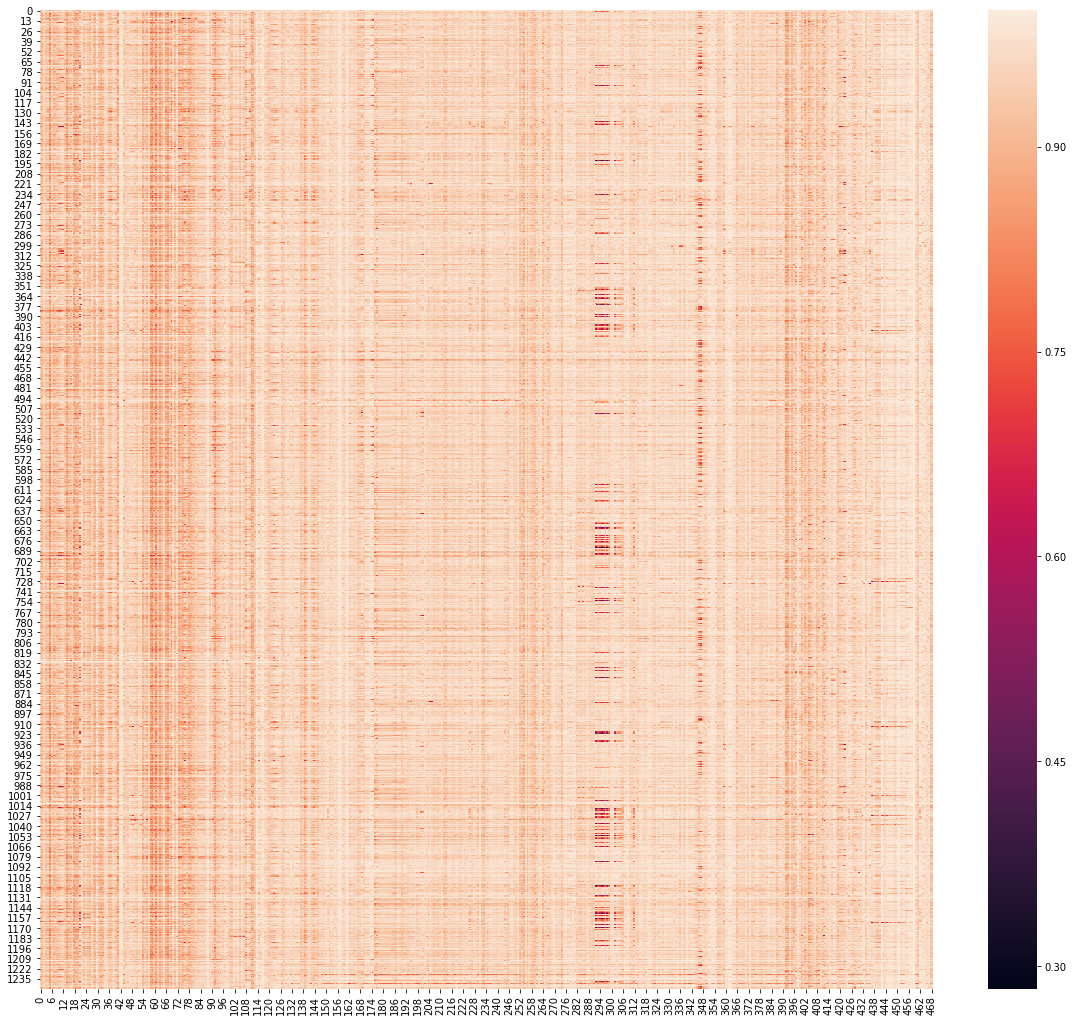

In [40]:
fig, ax = plt.subplots(figsize=(20,18))
ax = sns.heatmap(distances, ax=ax)

In [54]:
code[code['number'].map(lambda x: x in range(290, 301))]['name'].tolist()

['Получение взятки',
 'Дача взятки',
 'Служебный подлог',
 'Халатность',
 'Воспрепятствование осуществлению правосудия и производству предварительного расследования',
 'Посягательство на жизнь лица, осуществляющего правосудие или предварительное расследование',
 'Угроза или насильственные действия в связи с осуществлением правосудия или производством предварительного расследования',
 'Неуважение к суду',
 'Привлечение заведомо невиновного к уголовной ответственности или незаконное возбуждение уголовного дела',
 'Незаконное освобождение от уголовной ответственности']

In [108]:
for i in range(distances.shape[0]):
    df.loc[i, 'predicted'] = str([code.loc[j, 'number'] for j in distances[i].argsort()[:3]])

In [112]:
df['predicted'] = df['predicted'].map(eval)
df['labels'] = df['labels'].map(eval)

In [119]:
def intersection(row):
    return len(set(row['labels']).intersection(set(row['predicted'])))

df['intersection'] = df.apply(intersection, axis=1)

In [120]:
def has_intersection(row):
    if len(set(row['labels']).intersection(set(row['predicted']))) > 0:
        return 1
    return 0
df['is_right'] = df.apply(has_intersection, axis=1)

In [121]:
df['is_right'].sum() / df.shape[0]

0.5080128205128205

In [125]:
df[['case', 'labels', 'predicted', 'is_right', 'intersection']].head(15)

,case,labels,predicted,is_right,intersection
0,по постановлению мирового судьи <адрес> района...,"[264.1, 317.0, 389.15]","[300.0, 302.0, 295.0]",0,0
1,подсудимый городко ф.а. совершил угрозу убийст...,[119.0],"[6.0, 21.0, 22.0]",0,0
2,"подсудимые березкин с.и., мурсакулов э.а., род...","[33.0, 228.0, 33.0, 228.1, 33.0, 30.0, 228.1, ...","[228.0, 228.3, 229.1]",1,1
3,"подсудимый лебедев а.в. совершил преступление,...",[264.1],"[264.1, 104.5, 68.0]",1,1
4,гришанов сергей борисович совершил публичное о...,[319.0],"[6.0, 63.0, 61.0]",0,0
5,06 июня 2017 года в период времени с 21.30 час...,"[158.0, 73.0]","[22.0, 6.0, 60.0]",0,0
6,"<фио1> совершил покушение на кражу, то есть та...","[30.0, 158.0, 73.0, 81.0, 317.0]","[61.0, 68.0, 6.0]",0,0
7,приговором мирового судьи судебного участка № ...,"[264.1, 70.0, 73.0]","[8.0, 264.1, 70.0]",1,2
8,"<фио6> обвиняется в том, что она совершила пуб...",[319.0],"[63.0, 6.0, 61.0]",0,0
9,михайлов д.и. управлял автомобилем в состоянии...,"[264.1, 389.15]","[264.1, 70.0, 264.0]",1,1
